# MSDS 7333 - Week 4 Case Study: Future Contract Rolling

### Investigators
- [Matt Baldree](mailto:mbaldree@smu.edu?subject=lab2)
- [Ben Brock](bbrock@smu.edu?subject=lab2)
- [Tom Elkins](telkins@smu.edu?subject=lab2)
- [Austin Kelly](ajkelly@smu.edu?subject=lab2)


<div style='margin-left:10%;margin-right:10%;margin-top:15px;background-color:#d3d3d3;padding:5px;'>
    <h3>Instructions</h3>
    <p>Choose either the Signal Frontier Analysis application or Future Contract Rolling application.</p>
     <p>Steps:</p>
    <ol>
        <li>Use different stocks than those shown in examples.</li>
        <li>Create IPython Notebook, including code, output, and graphics.</li>
        <li>Include an introduction in your notebook to give background on your application.</li>
        <li>Be sure to explain calculations and output in the appropriate places.</li>
        <li>List outside references if used.</li>
        <li>The filename should incliude your first initial and last name and '_case study title'.</li>
    </ol> 
    <p>Report Sections:</p>
    <ol>
        <li>[Introduction](#introduction) <b>(5 points)</b></li>
        <li>[Background](#background) <b>(10 points)</b></li>
        <li>[Methods](#methods) <b>(30 points)</b></li>
        <li>[Results](#results) <b>(30 points)</b></li>
        <li>[Conclusion](#conclusion) <b>(5 points)</b></li>
        <li>[Bibliography and Citation](#biblio) <b>(5 points)</b></li>
        <li>[Code](#code) <b>(5 points)</b></li>
    </ol>
     <p>Other Grading Criterium:</p>
    <ol>
        <li>Grammar and Organization <b>(10 points)</b></li>
    </ol>
</div>

<a id='introduction'></a>
## 1 - Introduction
<div style='margin-left:10%;margin-right:10%;margin-top:15px;background-color:#d3d3d3;padding:10px;'>
<h3>Introduction (<b>5 points total</b>)</h3>
</div>

TODO

In [1]:
from __future__ import division
from __future__ import print_function
from pandas import Series, DataFrame
import pandas as pd
from pandas_datareader import data
from numpy.random import randn
import numpy as np
pd.options.display.max_rows = 12
np.set_printoptions(precision=4, suppress=True)

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(12, 6))

In [2]:
print('pandas 19.2 and pandas-datareader 0.2.1 required.')
print('pandas', pd.__version__)
print('numpy', np.__version__)
print('matplotlib', mpl.__version__)

pandas 19.2 and pandas-datareader 0.2.1 required.
pandas 0.19.2
numpy 1.11.3
matplotlib 2.0.0


In [3]:
%matplotlib inline
%pwd

'/Users/mattbaldree/Google Drive/smu/quantifying/QTW_04/QTW_04_Financial'

<a id="background"></a>
## 2 - Background

<div style='margin-left:10%;margin-right:10%;margin-top:15px;background-color:#d3d3d3;padding:10px;'>
<h3>Background (<b>10 points total</b>)</h3>
</div>

"A future is a ubiquitous form of derivative contract; it is an agreement to take delivery of a certain asset (such as oil, gold, or shares of the FTSE 100 index) on a particular date [1]." The 'particular date' is the expiration or expiry date. A future is often utilized to hedge the prices of a commodity but they can be used on anything [2].

Futures are volatile because they have an expiration or expiry. Contracts with nearest date of expiry are known as *near contract* [2]. At any point in time there could be many futures overlapping complicating which one should be traded. This is different than normal equity trading with a continuous time or contract. Therefore, the goal is to construct a continuous timeline for a set of futures contracts.

The difficulty in creating a continuous contract is the futures have different trade prices. There isn't a single standard method to join future contracts, but different approaches dependent on the contract and method of execution. Modeling futures is complicated by the time-limited nature of each contract because multiple contracts with different expiration dates may be traded. Often the contracts expiring sooner are more liquid meaning these are traded more often and have the lowest bid-ask spread. Common approaches to this problem include *Back/Forward ('Panama') Adjustment*, *Proportional Adjustment*, and *Rollover/Perpetual Series* [2].

This notebook will demonstrate the *Rollover/Perpetual Series* approach that creates a continuous contract by taking a linearly weighted proportion of each contract over a number of days. An illustration of this approach is provided by [2]. It is easier to model a contracts on a continuous return index indicating profit and loss. The contracts are weighted with active contracts given a one and others with a linear decay over a number of periods leadng up to expiration.
> For example consider five smoothing days. The price on day 1, P1 , is equal to 80% of the far contract price (F1) and 20% of the near contract price (N1). Similarly, on day 2 the price is P2=0.6×F2+0.4×N2. By day 5 we have P5=0.0×F5+1.0×N5=N5 and the contract then just becomes a continuation of the near price. Thus after five days the contract is smoothly transitioned from the far to the near.

Dynamic models allow us to simulate trading decision over a historic period. Moving window and exponentially weighted time series functions are an example of tools used to create dynamic models. Correlation and ordinary least squares can also be used to look at co-movement between the changes in two asset time series and differences in volatility.

<a id="methods"></a>
## 3 - Methods

<div style='margin-left:10%;margin-right:10%;margin-top:15px;background-color:#d3d3d3;padding:10px;'>
<h3>Methods (<b>30 points total</b>)</h3>

### Retrieve stock data for a list of stock symbols

In [4]:
# parameters
stock_names = ['SPY'] # SPDR S&P 500 ETF Trust
source = 'google'
start = '1/1/2015'
end = None

In [5]:
# retrieve stock data
stocks = data.DataReader(stock_names, 'google', start, end)
s_p = stocks['Close']
start_date = s_p.index[0]

# scale SPY to equivalent index value
s_p = s_p * 10

# print out panel axes
print(s_p.axes)
print(s_p.head())
print('')
print('Time series start date =', start_date)

[DatetimeIndex(['2015-01-02', '2015-01-05', '2015-01-06', '2015-01-07',
               '2015-01-08', '2015-01-09', '2015-01-12', '2015-01-13',
               '2015-01-14', '2015-01-15',
               ...
               '2017-05-15', '2017-05-16', '2017-05-17', '2017-05-18',
               '2017-05-19', '2017-05-22', '2017-05-23', '2017-05-24',
               '2017-05-25', '2017-05-26'],
              dtype='datetime64[ns]', name='Date', length=605, freq=None), Index(['SPY'], dtype='object')]
               SPY
Date              
2015-01-02  2054.3
2015-01-05  2017.2
2015-01-06  1998.2
2015-01-07  2023.1
2015-01-08  2059.0

Time series start date = 2015-01-02 00:00:00


### Create Futures

In [6]:
# simulate contracts in the future with random walk and noise
np.random.seed(12347)
N = 200

# N size array of random numnber between 0-200 - 100, then x 0.25
walk = (np.random.randint(0, 200, size=N) - 100) * 0.25
# N size array of random numnber between 0-100 - 10, then x 0.25
noise = (np.random.randint(0, 20, size=N) - 10) * 0.25
# cumulative sum 
walk = walk.cumsum()

# create a date range to be used for prices index
rng = pd.date_range(s_p.index[0], periods=len(s_p) + N, freq='B')
# create near term future contract by appending data = last price plus walk increase
near = np.concatenate([s_p.values.ravel(), s_p.values[-1].ravel() + walk])
# create far term future contract by appending data = last price plus walk and noise increase
far = np.concatenate([s_p.values.ravel(), s_p.values[-1].ravel() + walk + noise])

# new dataframe with the two contracts
prices = DataFrame({'ESU2': near, 'ESZ2': far}, index=rng)

print('Futures estimated pricing:\n\n', prices.tail())

Futures estimated pricing:

                ESU2     ESZ2
2018-01-26  2446.35  2448.10
2018-01-29  2432.60  2434.85
2018-01-30  2440.60  2442.35
2018-01-31  2457.10  2456.35
2018-02-01  2437.10  2434.85


### Determine Rolled Returns

Splice time series together into a single continuous series by a weighting matrix. Active contracts receive a weight of one until expiry date. After expiry date, a roll convention is used.

In [7]:
# create expiry dates
from datetime import datetime
expiry_dates = {'ESU2': datetime(2016, 9, 21),
           'ESZ2': datetime(2016, 12, 21)}
expiry_dates = Series.sort_values(Series(expiry_dates))
print(expiry_dates)

ESU2   2016-09-21
ESZ2   2016-12-21
dtype: datetime64[ns]


In [8]:
def get_roll_weights(start, expiry_dates, futures, roll_periods=5):
    """
    This constructs a pandas DataFrame that contains weights (between 0.0 and 1.0)
    of contract positions to hold in order to carry out a rollover of rollover_days
    prior to the expiration of the earliest contract. The matrix can then be
    'multiplied' with another DataFrame containing the settle prices of each
    contract in order to produce a continuous time series futures contract.
    
    Args:
        start: first date to compute weighting DataFrame
        expiry: Series of ticker expiration dates
        items: sequence of contract names
    """
    
    # create business days from start to last expiry
    dates = pd.date_range(start, expiry_dates[-1], freq='B')
    # initialize weights to 0.0
    weights = DataFrame(np.zeros((len(dates), len(futures))), index=dates, columns=futures)
    
    # set to first date
    prev_date = weights.index[0]
    
    # loop through futures and create weights depending upon expiry and rollover days (periods)
    # i=iteration, item=name of future, ex_date=date of expiry
    for i, (future, ex_date) in enumerate(expiry_dates.iteritems()):
        # if i < 1
        if i < len(expiry_dates) - 1:
            business_day = pd.offsets.BDay()
            # set weights to 1 for future from prev_date to ex_date-1 day
            weights.ix[prev_date:ex_date - business_day, future] = 1
            # determine dates for decay weights
            roll_rng = pd.date_range(end=ex_date - business_day,
                                     periods=roll_periods + 1, freq='B')
            
            # create roll weights to use for future from 0. to 1.
            decay_weights = np.linspace(0, 1, roll_periods + 1)
            weights.ix[roll_rng, future] = 1 - decay_weights
            weights.ix[roll_rng, expiry_dates.index[i + 1]] = decay_weights
        else:
            weights.ix[prev_date:, future] = 1
            
        prev_date = ex_date
    
    return weights

Get rolling weights from start date for each contract

In [9]:
weights = get_roll_weights(start_date, expiry_dates, prices.columns)
print(weights.ix['2016-09-12':'2016-09-21'])

            ESU2  ESZ2
2016-09-12   1.0   0.0
2016-09-13   1.0   0.0
2016-09-14   0.8   0.2
2016-09-15   0.6   0.4
2016-09-16   0.4   0.6
2016-09-19   0.2   0.8
2016-09-20   0.0   1.0
2016-09-21   0.0   1.0


In [10]:
rolled_prices = (prices * weights).dropna().sum(1).dropna()
rolled_returns = (prices.pct_change() * weights).dropna().sum(1)
rolled_results = pd.concat([rolled_prices, rolled_returns], axis=1)
rolled_results.columns = ['price', 'return']

print(rolled_results)

             price    return
2015-01-02  2054.3       NaN
2015-01-05  2017.2 -0.018060
2015-01-06  1998.2 -0.009419
2015-01-07  2023.1  0.012461
2015-01-08  2059.0  0.017745
2015-01-09  2042.5 -0.008014
...            ...       ...
2016-12-14  2264.6 -0.003301
2016-12-15  2264.6  0.000000
2016-12-16  2271.0  0.002826
2016-12-19  2265.3 -0.002510
2016-12-20  2270.5  0.002296
2016-12-21  2262.5 -0.003523

[514 rows x 2 columns]


### Visualization

Correlation is a way to look at co-movement between changes in two asset time series [1]. 

In [11]:
# parameters
stock_names = ['AMZN', 'GOOG']
source = 'google'
start = '1/4/2012'
end = None

# retrieve stock data
stocks = data.DataReader(stock_names, 'google', start, end)['Close']
print(stocks.axes)
print(stocks.AMZN.pct_change())

[DatetimeIndex(['2012-01-04', '2012-01-05', '2012-01-06', '2012-01-09',
               '2012-01-10', '2012-01-11', '2012-01-12', '2012-01-13',
               '2012-01-17', '2012-01-18',
               ...
               '2017-05-15', '2017-05-16', '2017-05-17', '2017-05-18',
               '2017-05-19', '2017-05-22', '2017-05-23', '2017-05-24',
               '2017-05-25', '2017-05-26'],
              dtype='datetime64[ns]', name='Date', length=1358, freq=None), Index(['AMZN', 'GOOG'], dtype='object')]
Date
2012-01-04         NaN
2012-01-05    0.000563
2012-01-06    0.028152
2012-01-09   -0.022178
2012-01-10    0.004368
2012-01-11   -0.002453
                ...   
2017-05-19    0.001408
2017-05-22    0.011283
2017-05-23    0.000896
2017-05-24    0.009068
2017-05-25    0.013291
2017-05-26    0.002416
Name: AMZN, dtype: float64


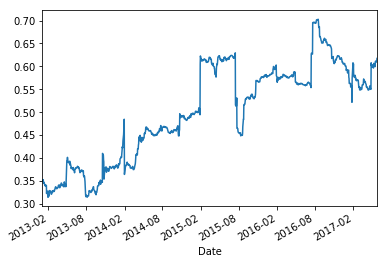

In [12]:
stockA = stocks.AMZN.pct_change()
stockB = stocks.GOOG.pct_change()

# plot one year moving correlation
stockA.rolling(window=250).corr(stockB).dropna().plot()

Ordinary Least Squares (OLS) Regression to model relationship between a variable and one or more other predictor variables.

/Users/mattbaldree/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: The pandas.stats.ols module is deprecated and will be removed in a future version. We refer to external packages like statsmodels, see some examples here: http://www.statsmodels.org/stable/regression.html
  if __name__ == '__main__':


                GOOG  intercept
Date                           
2013-01-03  0.487584   0.001492
2013-01-04  0.486031   0.001435
2013-01-07  0.491755   0.001445
2013-01-08  0.489788   0.001425
2013-01-09  0.489216   0.001396
2013-01-10  0.489109   0.001391
...              ...        ...
2017-05-19  0.725929   0.000494
2017-05-22  0.733106   0.000530
2017-05-23  0.731709   0.000511
2017-05-24  0.733766   0.000484
2017-05-25  0.740648   0.000534
2017-05-26  0.739205   0.000492

[1108 rows x 2 columns]


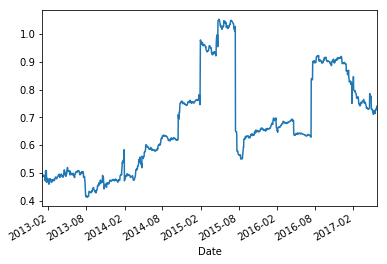

In [13]:
model = pd.ols(y=stockA, x={'GOOG': stockB}, window=250)
print(model.beta)
model.beta.GOOG.plot()

<a id="results"></a>
## 4 - Results

<div style='margin-left:10%;margin-right:10%;margin-top:15px;background-color:#d3d3d3;padding:10px;'>
<h3>Results (<b>30 points total</b>)</h3>

<a id="conclusion"></a>
## 5 - Conclusion

<div style='margin-left:10%;margin-right:10%;margin-top:15px;background-color:#d3d3d3;padding:10px;'>
<h3>Conclusion (<b>5 points total</b>)</h3>

<a id="biblio"></a>
## 6 - Bibliography and Citation

<div style='margin-left:10%;margin-right:10%;margin-top:15px;background-color:#d3d3d3;padding:10px;'>
<h3>Bibliography and Citation (<b>5 points total</b>)</h3>
</div>

- [1] Python for Data Analysis, pgs. 344-348.
- [2] Halls-Moore, Michael; Continuous Futures Contracts for Backtesting Purposes; Jan. 29th, 2014; https://www.quantstart.com/articles/Continuous-Futures-Contracts-for-Backtesting-Purposes.

<a id="code"></a>
## 7 - Code

<div style='margin-left:10%;margin-right:10%;margin-top:15px;background-color:#d3d3d3;padding:10px;'>
<h3>Code (5 points)</h3>
</div>

See code in Methods section